### COSC102 Assignment 3 - Prepare Data
The purpose of this notebook is to prepare the data for the model training.
We will use the data from the IMU sensor to train a model to predict the activity of the user.



In [1]:
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import dtreeviz

# Set some lists to store the IMU data.

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []


def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side-Step':
        return 3
    elif activity_string == 'Running':
        return 4

In [2]:
# Read the IMU data from the csv file.
with open ('./datasets/a3_imu_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time_track.append(float(row[0]))
        ax_set.append(float(row[1]))
        ay_set.append(float(row[2]))
        az_set.append(float(row[3]))
        gx_set.append(float(row[4]))
        gy_set.append(float(row[5]))
        gz_set.append(float(row[6]))

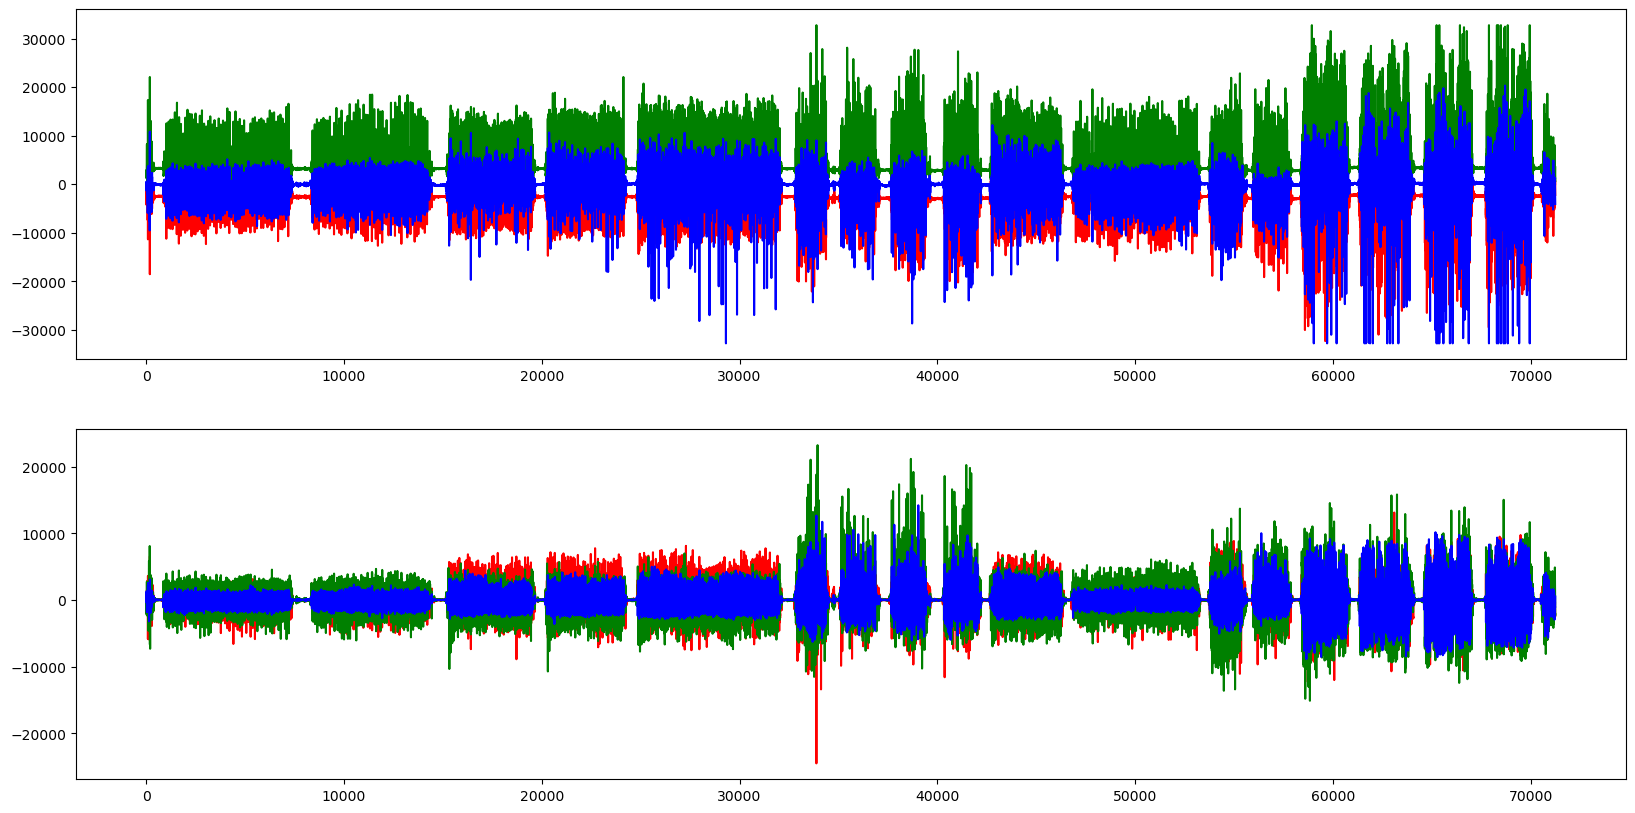

In [3]:
# Check the raw IMU data from the csv file.
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')

start_ts:  1598240221.0


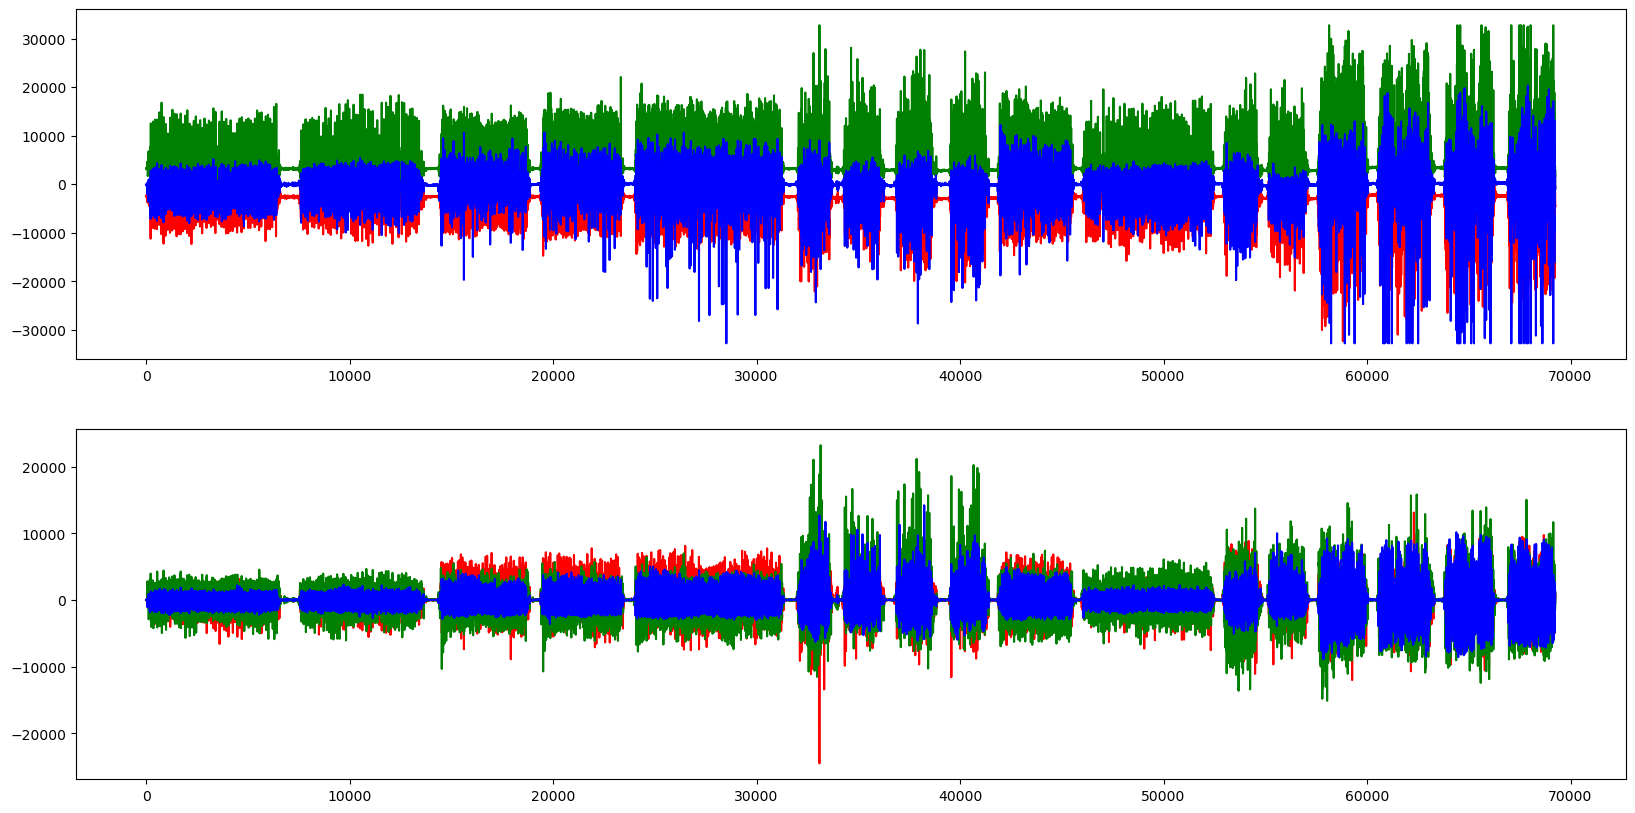

In [4]:
start_idx = 800

start_ts = time_track[start_idx]
print('start_ts: ', start_ts)

end_idx = time_track.index(start_ts + 711)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

In [5]:
# Add activity annotation to the IMU data from the csv file.
with open ('./datasets/a3_activity_annotations.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip the headers
    for row in reader:
        time_stamp = (row[0].split('='))[1]
        activity_set.append([float(time_stamp),row[-1], map_activity(row[-1])])

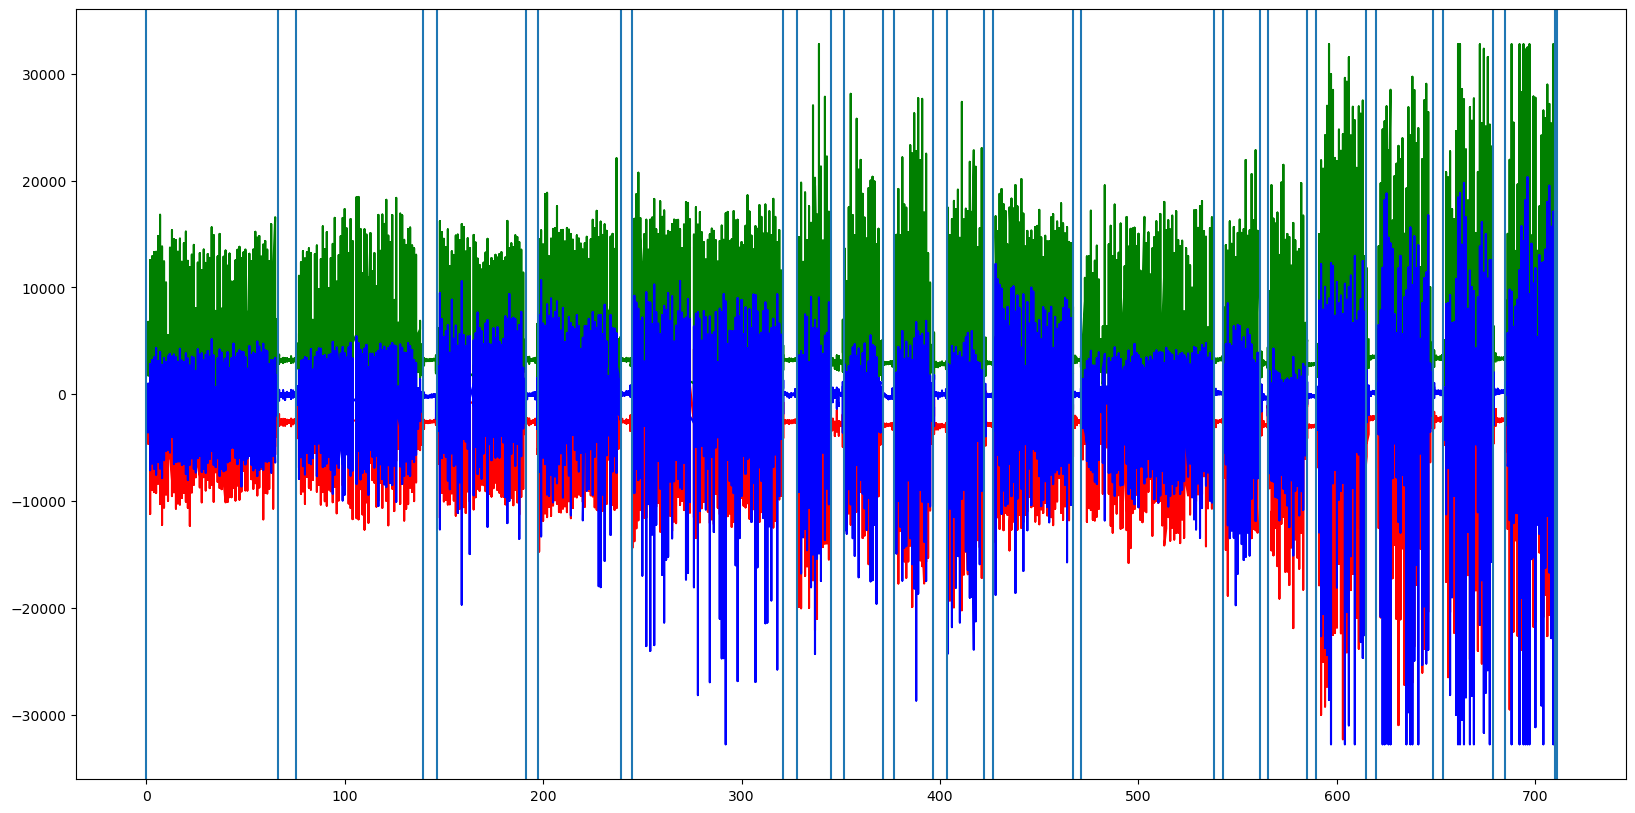

In [6]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = []
activity_string_timeseries = []
activity_idx = 0

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

# #Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

ig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

(array([ 8892., 19341., 19496., 11303., 10218.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

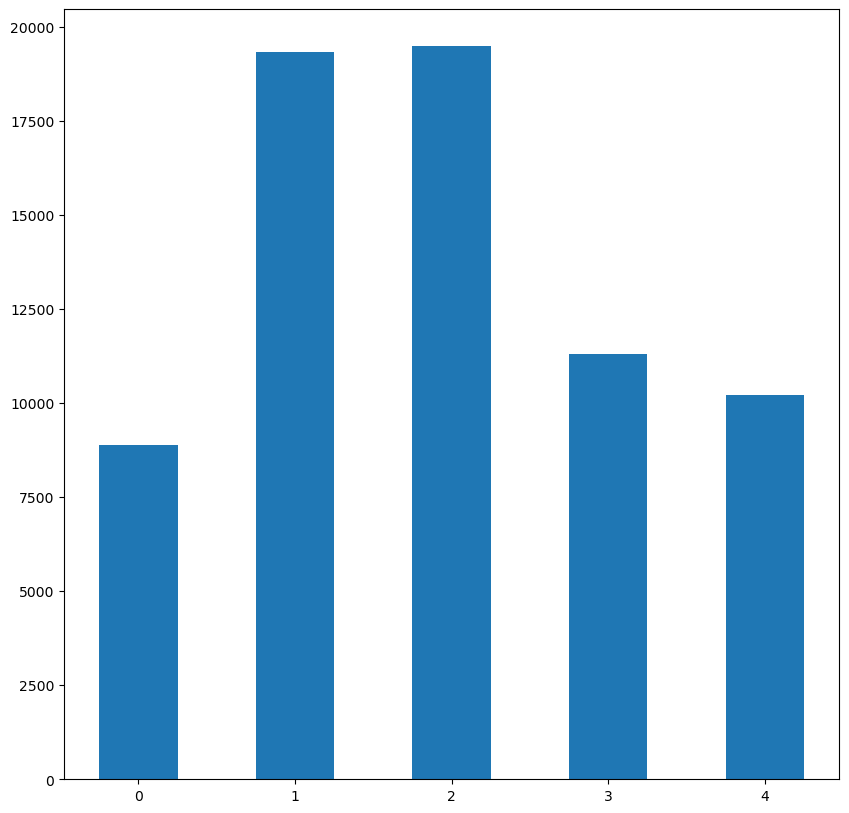

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries, bins=[-0.5,0.5,1.5,2.5,3.5, 4.5] , rwidth=0.5, align='mid')

In [8]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

In [9]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0
bad_data_point = [104, 105, 163, 164, 274, 275]            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    
    if t in bad_data_point:
      continue
    
    #The index function finds the index of the first occurance of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)



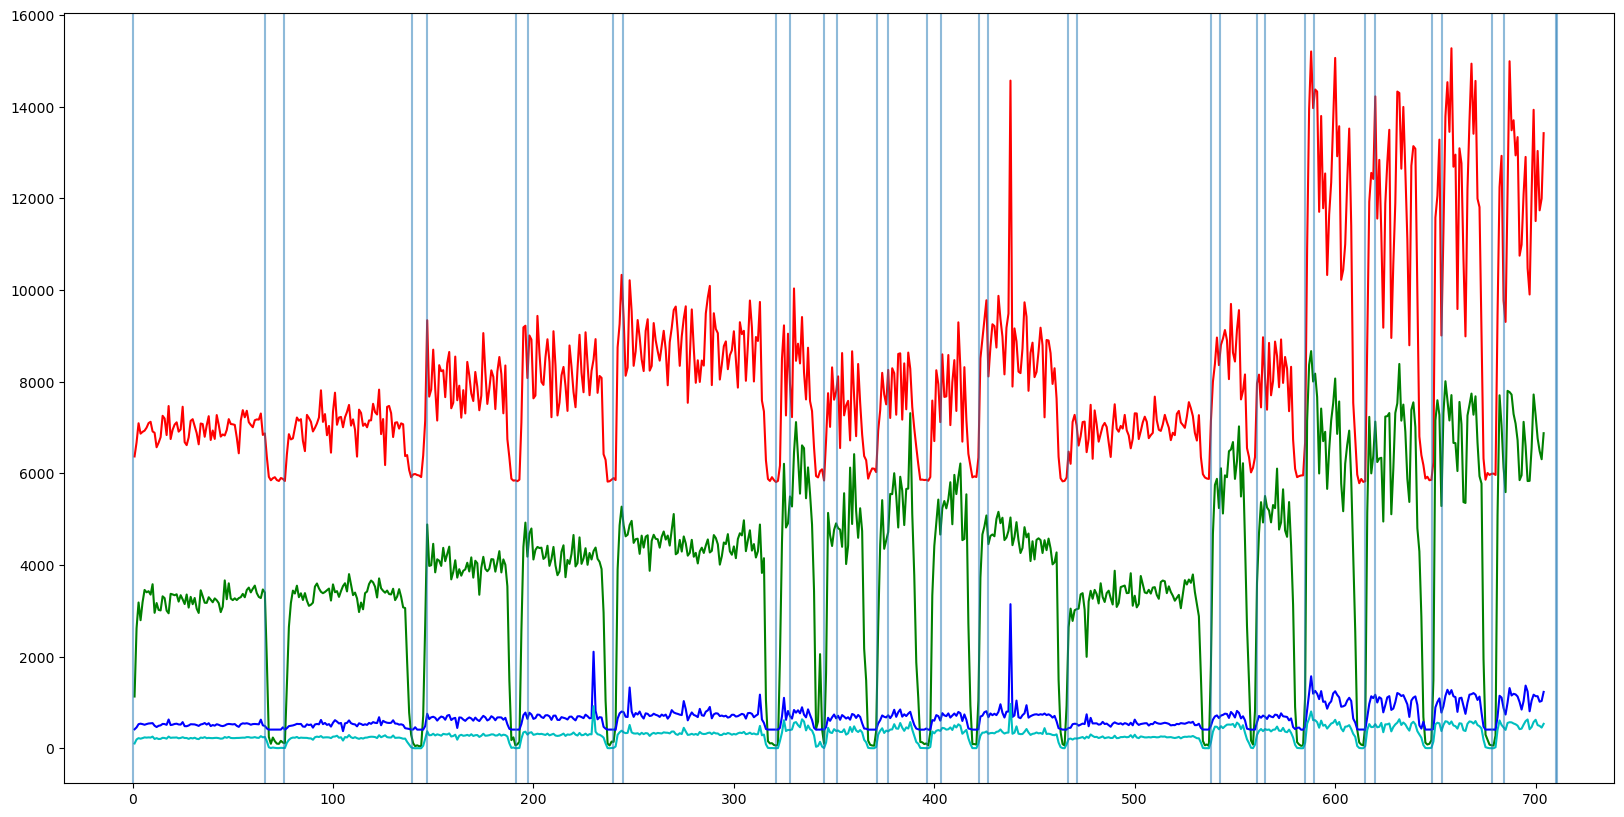

In [10]:
# Lets visualise some of the features just out of interest - we will look at the SMA and AI
plot_range = range(1,705)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(plot_range,np.array(feature_set)[:,18], color='r')
ax.plot(plot_range,np.array(feature_set)[:,19], color='g')
ax.plot(plot_range,np.array(feature_set)[:,20], color='b')
ax.plot(plot_range,np.array(feature_set)[:,21], color='c')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)
    

In [11]:
feature_set = np.array(feature_set)
target_set = np.array(target_set)

### Support Vector Machine / Stochastic Gradient Descendent

In [12]:
target_names = list(['Jogging', 'Running', 'Side-Step', 'Standing', 'Walking'])
nclasses = len(target_names)

# train and test datasets
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, random_state=42)

# standardise mean and std as the SGD classifier will be used.
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

In [13]:
# check the alpha range for the SGD classifier 
# keep adjusting to hone in on the best value
alpha_range = np.arange(0.00025, 0.00036, 0.00001)
print(alpha_range)

[0.00025 0.00026 0.00027 0.00028 0.00029 0.0003  0.00031 0.00032 0.00033
 0.00034 0.00035]


In [14]:
#initialise highest performing variables
best_performance = 0
best_f1 = 0
best_f2 = 0
best_alpha = 0
f1_set = np.zeros(22)

# loop through and store all of the 2 most higher performing features for each alpha
for alpha in alpha_range:
    for f1 in range(0, 22):
        for f2 in range(0, 22):
            if f1 == f2:
                continue

            features_idx_to_use = [f1, f2]
            clf = SGDClassifier(alpha=alpha, random_state=42)
            clf.fit(X_train[:, features_idx_to_use], y_train)

            # Return the predictions for the 3-Fold crossvalidation
            y_predicted = cross_val_predict(
                clf, X_train[:, features_idx_to_use], y_train)

            # Store the result
            current_f1 = np.mean(f1_score(y_train, y_predicted, average=None))
            f1_set[features_idx_to_use] = current_f1
            
            if current_f1 > best_performance:
                best_f1 = f1
                best_f2 = f2
                best_performance = current_f1
                best_clf = clf
                best_alpha = alpha

In [15]:
# standardise the the mean value of X_test as it must be fit into the best SGD in previous step.
X_test = (X_test - mean) / std
y_test_predicted = best_clf.predict(X_test[:, [best_f1, best_f2]])
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# calculate recall, precision and F1 scores for each class
print("Recall Score:", recall_score(y_train,y_predicted,average=None))
print("Precision Score:", precision_score(y_train,y_predicted,average=None))
print("F1 Score:", f1_score(y_train,y_predicted,average=None))
print("Stored mean f1 through each loop", f1_set)
print("Best f1:", best_f1)
print("Best f2:", best_f2)
print("Best alpha:", best_alpha)

Recall Score: [0.88235294 0.85714286 0.75       0.75294118 0.8045977 ]
Precision Score: [0.89552239 0.80536913 0.80434783 0.82051282 0.72916667]
F1 Score: [0.88888889 0.83044983 0.77622378 0.78527607 0.76502732]
Stored mean f1 through each loop [0.61492691 0.61534467 0.59927351 0.49695671 0.53213338 0.5366207
 0.73329965 0.56498729 0.68879605 0.64588342 0.68010678 0.6079219
 0.58963845 0.64868379 0.51724544 0.56456767 0.51135269 0.56216446
 0.74181338 0.5816445  0.80917318 0.80917318]
Best f1: 6
Best f2: 10
Best alpha: 0.0003300000000000002


Text(0.5, 1.0, 'Best classified F1 Scores')

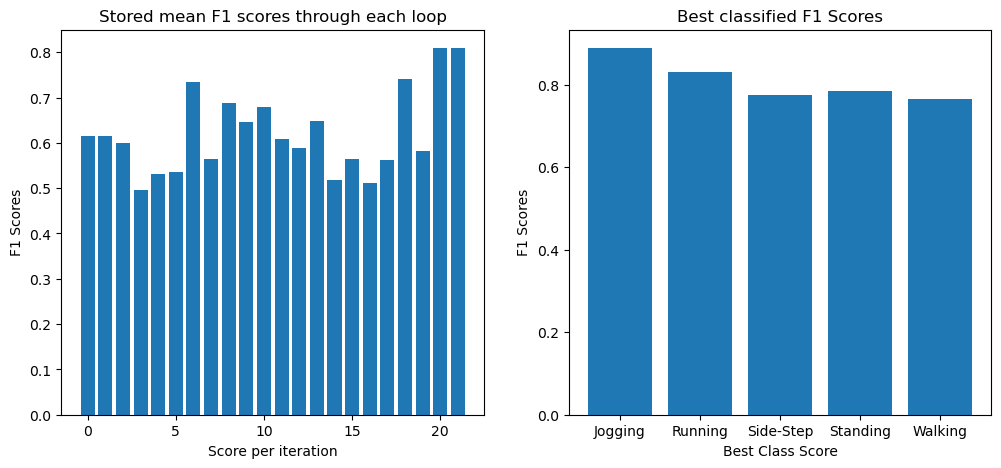

In [16]:
# Plot f1_scores for each iteration
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
ax1.bar(range(22),f1_set)
ax1.plot()
ax1.set_xlabel('Score per iteration')
ax1.set_ylabel('F1 Scores')
ax1.set_title('Stored mean F1 scores through each loop')

ax2.bar(target_names, f1_score(y_train,y_predicted,average=None))
ax2.set_xlabel('Best Class Score')
ax2.set_ylabel('F1 Scores')
ax2.set_title('Best classified F1 Scores')


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, '3-Fold Training')

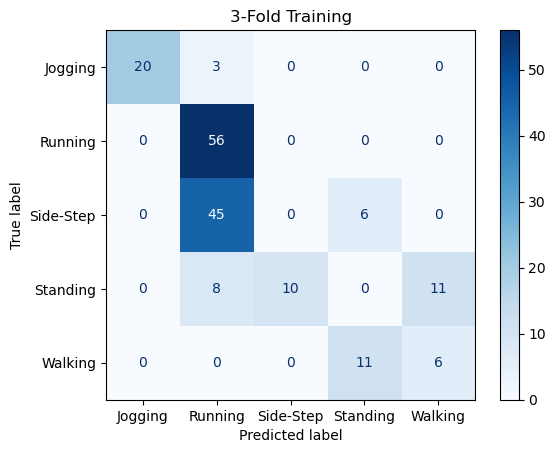

In [22]:
# Plot the confusion matrices
fig, ax = plt.subplots()
plot_confusion_matrix(best_clf, X_test[:, features_idx_to_use], y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('3-Fold Training')

In [18]:
y_score = best_clf.decision_function(X_test[:,[best_f1, best_f2]])

# format the y_test into a n_samples x 5 binary array that indicates class membership
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4]) 

# Plot a ROC curve and calculate the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nclasses):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

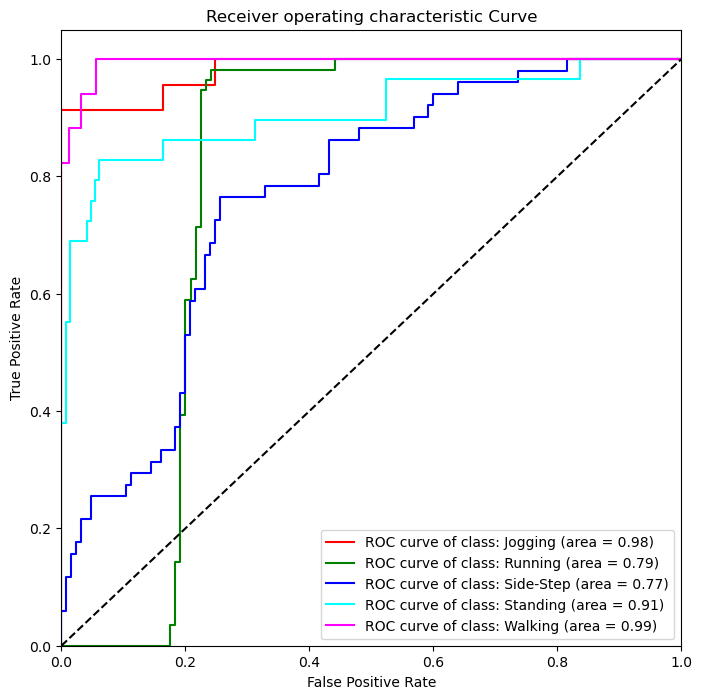

In [19]:
# Plot the TPR vs FPR for each class
fig, ax = plt.subplots(figsize=(8,8))
colors = ['red', 'green', 'blue', 'cyan', 'magenta']
for i, color in zip(range(nclasses), colors):
    ax.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class: {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))
    
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic Curve')
ax.legend(loc="lower right")

In [20]:
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X_test[:, best_f1].min() - 1, X_test[:, best_f1].max() + 1
y_min, y_max = X_test[:, best_f2].min() - 1, X_test[:, best_f2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

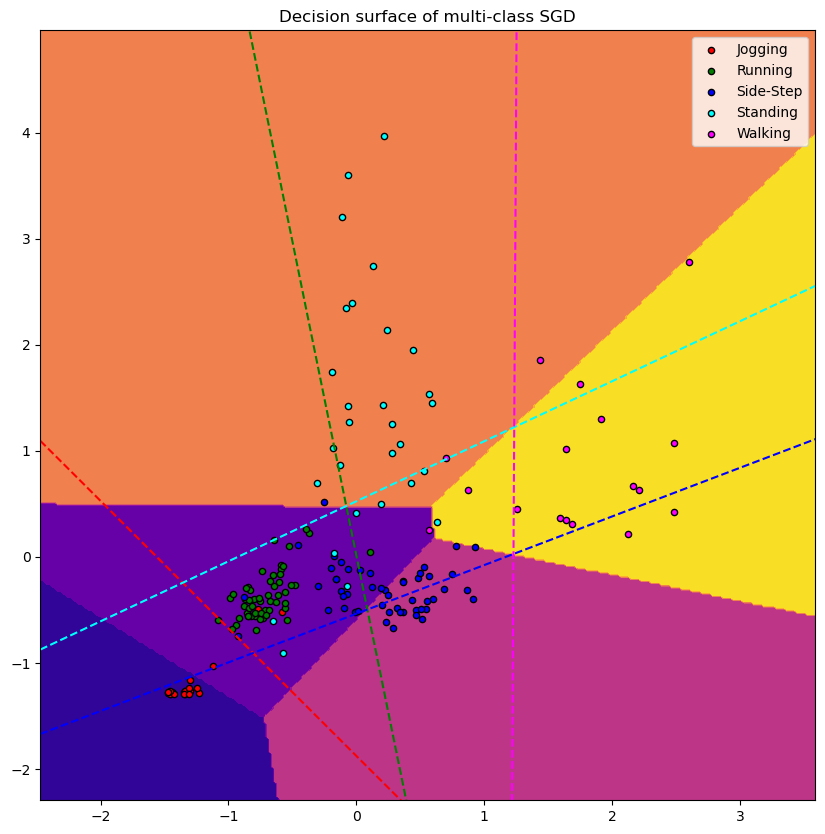

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
# Plot the decision boundary. Put the result into a color plot
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = ax.contourf(xx, yy, Z, cmap=plt.get_cmap("plasma"))

colors = ['red', 'green', 'blue', 'cyan', 'magenta']
# Plot also the training points
for i, color in zip(best_clf.classes_, colors):
    idx = np.where(y_test == i)
    ax.scatter(X_test[idx, best_f1], X_test[idx, best_f2], c=color, label=target_names[i],
                cmap=plt.get_cmap("plasma"), edgecolor='black', s=20)
ax.set_title("Decision surface of multi-class SGD")
ax.axis('tight')
ax.legend()


# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = best_clf.coef_
intercept = best_clf.intercept_

def plot_hyperplane(c, color):
    # hyperplane plotting for each class.
    def line(x0) -> float:
        # calculates the position of the line
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)

for i, color in zip(best_clf.classes_, colors):
    plot_hyperplane(i, color)